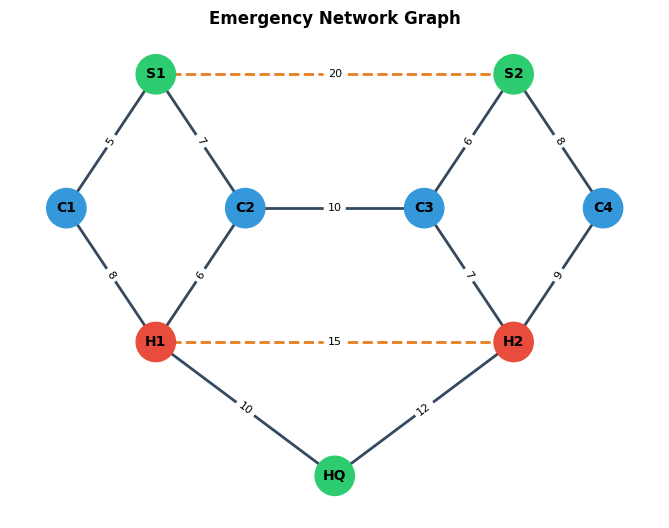

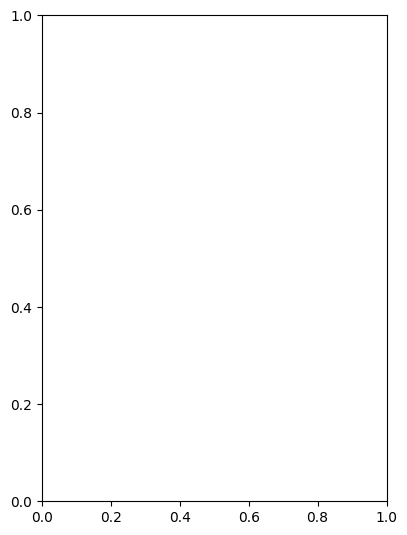

In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox, scrolledtext
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.patches import Circle, FancyArrowPatch
import networkx as nx
import heapq
from collections import defaultdict
import math

class EmergencyNetworkSimulator:
    def __init__(self, root):
        self.root = root
        self.root.title("Interactive Emergency Network Simulator")
        self.root.geometry("1600x950")
        
        # Network data structures
        self.graph = nx.Graph()
        self.tree_structure = {} 
        self.node_positions = {}
        self.selected_nodes = []
        self.vulnerable_edges = set()
        self.failed_nodes = set()
        
        # Colors
        self.SUPPLY_CENTER_COLOR = '#2ecc71'  
        self.CRITICAL_HUB_COLOR = '#e74c3c'   
        self.NORMAL_NODE_COLOR = '#3498db'   
        self.FAILED_NODE_COLOR = '#95a5a6'    
        self.MST_EDGE_COLOR = '#f39c12'     
        self.NORMAL_EDGE_COLOR = '#34495e'    
        self.VULNERABLE_EDGE_COLOR = '#e67e22' 
        
        self.setup_ui()
        self.create_sample_network()
        
    def setup_ui(self):

        main_frame = ttk.Frame(self.root, padding="5")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        self.root.columnconfigure(0, weight=1)
        self.root.rowconfigure(0, weight=1)
        
    
        title = ttk.Label(main_frame, text="Emergency Communication & Response Network", 
                         font=('Arial', 16, 'bold'))
        title.grid(row=0, column=0, columnspan=3, pady=5)
        

        self.setup_control_panel(main_frame)

        self.setup_graph_panel(main_frame)
        

        self.setup_tree_panel(main_frame)

        self.setup_results_panel(main_frame)
        
    def setup_control_panel(self, parent):
        control_frame = ttk.LabelFrame(parent, text="Control Panel", padding="10")
        control_frame.grid(row=1, column=0, sticky=(tk.W, tk.E, tk.N, tk.S), padx=5)
   
        ttk.Label(control_frame, text="📍 Network Builder", 
                 font=('Arial', 11, 'bold')).pack(anchor='w', pady=(0, 5))
        

        node_frame = ttk.LabelFrame(control_frame, text="Add Node", padding="5")
        node_frame.pack(fill='x', pady=5)
        
        ttk.Label(node_frame, text="Node ID:").grid(row=0, column=0, sticky='w')
        self.node_id_entry = ttk.Entry(node_frame, width=15)
        self.node_id_entry.grid(row=0, column=1, pady=2)
        
        ttk.Label(node_frame, text="Type:").grid(row=1, column=0, sticky='w')
        self.node_type = ttk.Combobox(node_frame, width=13, 
                                     values=['Normal', 'Supply Center', 'Critical Hub'])
        self.node_type.set('Normal')
        self.node_type.grid(row=1, column=1, pady=2)
        
        ttk.Button(node_frame, text="Add Node", 
                  command=self.add_node).grid(row=2, column=0, columnspan=2, pady=5)
        
        # Add Edge
        edge_frame = ttk.LabelFrame(control_frame, text="Add Road/Connection", padding="5")
        edge_frame.pack(fill='x', pady=5)
        
        ttk.Label(edge_frame, text="From:").grid(row=0, column=0, sticky='w')
        self.edge_from = ttk.Entry(edge_frame, width=15)
        self.edge_from.grid(row=0, column=1, pady=2)
        
        ttk.Label(edge_frame, text="To:").grid(row=1, column=0, sticky='w')
        self.edge_to = ttk.Entry(edge_frame, width=15)
        self.edge_to.grid(row=1, column=1, pady=2)
        
        ttk.Label(edge_frame, text="Weight:").grid(row=2, column=0, sticky='w')
        self.edge_weight = ttk.Entry(edge_frame, width=15)
        self.edge_weight.insert(0, "10")
        self.edge_weight.grid(row=2, column=1, pady=2)
        
        self.vulnerable_var = tk.BooleanVar()
        ttk.Checkbutton(edge_frame, text="Vulnerable Road", 
                       variable=self.vulnerable_var).grid(row=3, column=0, columnspan=2)
        
        ttk.Button(edge_frame, text="Add Road", 
                  command=self.add_edge).grid(row=4, column=0, columnspan=2, pady=5)
        
        # Algorithm Section
        ttk.Label(control_frame, text=" Algorithms", 
                 font=('Arial', 11, 'bold')).pack(anchor='w', pady=(10, 5))
        
        ttk.Button(control_frame, text="Q1: Generate MST (Kruskal)", 
                  command=self.generate_mst, width=25).pack(fill='x', pady=2)
        
        ttk.Button(control_frame, text="Q2: Find K Reliable Paths", 
                  command=self.find_reliable_paths, width=25).pack(fill='x', pady=2)
        
        ttk.Button(control_frame, text="Q3: Optimize Command Tree", 
                  command=self.optimize_command_tree, width=25).pack(fill='x', pady=2)
        
        ttk.Button(control_frame, text="Q4: Simulate Failure", 
                  command=self.simulate_failure, width=25).pack(fill='x', pady=2)
        
        ttk.Button(control_frame, text="Bonus: Graph Coloring", 
                  command=self.graph_coloring, width=25).pack(fill='x', pady=2)
        
        # Utility buttons
        ttk.Label(control_frame, text=" Utilities", 
                 font=('Arial', 11, 'bold')).pack(anchor='w', pady=(10, 5))
        
        ttk.Button(control_frame, text="Clear Selection", 
                  command=self.clear_selection, width=25).pack(fill='x', pady=2)
        
        ttk.Button(control_frame, text="Reset Network", 
                  command=self.create_sample_network, width=25).pack(fill='x', pady=2)
        
        ttk.Button(control_frame, text="Clear All", 
                  command=self.clear_all, width=25).pack(fill='x', pady=2)
        
    def setup_graph_panel(self, parent):
        graph_frame = ttk.LabelFrame(parent, text="Network Graph Visualization", padding="5")
        graph_frame.grid(row=1, column=1, sticky=(tk.W, tk.E, tk.N, tk.S), padx=5)
        
        parent.columnconfigure(1, weight=3)
        parent.rowconfigure(1, weight=1)
        
        # Matplotlib figure
        self.graph_fig, self.graph_ax = plt.subplots(figsize=(10, 8))
        self.graph_canvas = FigureCanvasTkAgg(self.graph_fig, graph_frame)
        self.graph_canvas.get_tk_widget().pack(fill='both', expand=True)
        
        # Click event
        self.graph_canvas.mpl_connect('button_press_event', self.on_graph_click)
        
        # Info label
        self.info_label = ttk.Label(graph_frame, text="Click nodes to select for path finding", 
                                   foreground='blue')
        self.info_label.pack(pady=2)
        
    def setup_tree_panel(self, parent):
        tree_frame = ttk.LabelFrame(parent, text="🌲 Command Hierarchy Tree", padding="5")
        tree_frame.grid(row=1, column=2, sticky=(tk.W, tk.E, tk.N, tk.S), padx=5)
        
        parent.columnconfigure(2, weight=1)
        
        # Tree visualization
        self.tree_fig, self.tree_ax = plt.subplots(figsize=(5, 8))
        self.tree_canvas = FigureCanvasTkAgg(self.tree_fig, tree_frame)
        self.tree_canvas.get_tk_widget().pack(fill='both', expand=True)
        
    def setup_results_panel(self, parent):
        results_frame = ttk.LabelFrame(parent, text="Results & Analysis", padding="5")
        results_frame.grid(row=2, column=0, columnspan=3, sticky=(tk.W, tk.E), pady=5)
        
        self.results_text = scrolledtext.ScrolledText(results_frame, height=12, 
                                                     wrap=tk.WORD, font=('Courier', 9))
        self.results_text.pack(fill='both', expand=True, padx=5, pady=5)
        
    def create_sample_network(self):
        self.graph.clear()
        self.failed_nodes.clear()
        self.vulnerable_edges.clear()
        self.selected_nodes.clear()
        
  
        nodes = {
            'HQ': {'type': 'Supply Center', 'pos': (0, 0)},
            'H1': {'type': 'Critical Hub', 'pos': (-2, 1)},
            'H2': {'type': 'Critical Hub', 'pos': (2, 1)},
            'C1': {'type': 'Normal', 'pos': (-3, 2)},
            'C2': {'type': 'Normal', 'pos': (-1, 2)},
            'C3': {'type': 'Normal', 'pos': (1, 2)},
            'C4': {'type': 'Normal', 'pos': (3, 2)},
            'S1': {'type': 'Supply Center', 'pos': (-2, 3)},
            'S2': {'type': 'Supply Center', 'pos': (2, 3)},
        }
        
        for node_id, attrs in nodes.items():
            self.graph.add_node(node_id, **attrs)
            self.node_positions[node_id] = attrs['pos']
     
        edges = [
            ('HQ', 'H1', 10), ('HQ', 'H2', 12),
            ('H1', 'C1', 8), ('H1', 'C2', 6),
            ('H2', 'C3', 7), ('H2', 'C4', 9),
            ('C1', 'S1', 5), ('C2', 'S1', 7),
            ('C3', 'S2', 6), ('C4', 'S2', 8),
            ('H1', 'H2', 15), ('C2', 'C3', 10),
            ('S1', 'S2', 20)
        ]
        
        for u, v, w in edges:
            self.graph.add_edge(u, v, weight=w)
        
        # Mark some as vulnerable
        self.vulnerable_edges = {('H1', 'H2'), ('S1', 'S2')}
        
        self.visualize_graph()
        self.log_result("Sample emergency network created with 9 nodes and 13 connections.")
        
    def add_node(self):
        node_id = self.node_id_entry.get().strip()
        if not node_id:
            messagebox.showerror("Error", "Please enter a node ID")
            return
        
        if node_id in self.graph:
            messagebox.showerror("Error", f"Node {node_id} already exists")
            return

        import random
        pos = (random.uniform(-3, 3), random.uniform(0, 3))
        
        self.graph.add_node(node_id, type=self.node_type.get(), pos=pos)
        self.node_positions[node_id] = pos
        
        self.visualize_graph()
        self.log_result(f"Added node: {node_id} ({self.node_type.get()})")
        
    def add_edge(self):
        from_node = self.edge_from.get().strip()
        to_node = self.edge_to.get().strip()
        
        if not from_node or not to_node:
            messagebox.showerror("Error", "Please enter both nodes")
            return
        
        if from_node not in self.graph or to_node not in self.graph:
            messagebox.showerror("Error", "One or both nodes don't exist")
            return
        
        try:
            weight = float(self.edge_weight.get())
        except:
            messagebox.showerror("Error", "Invalid weight")
            return
        
        self.graph.add_edge(from_node, to_node, weight=weight)
        
        if self.vulnerable_var.get():
            self.vulnerable_edges.add((from_node, to_node))
            self.vulnerable_edges.add((to_node, from_node))
        
        self.visualize_graph()
        vuln = " (Vulnerable)" if self.vulnerable_var.get() else ""
        self.log_result(f"Added road: {from_node} ↔ {to_node}, weight={weight}{vuln}")
        
    def generate_mst(self):
        """Q1: Generate Minimum Spanning Tree using Kruskal's algorithm"""
        if len(self.graph.nodes()) == 0:
            messagebox.showerror("Error", "No nodes in network")
            return
        
        self.log_result("\n" + "="*80)
        self.log_result("Q1: MINIMUM SPANNING TREE (Kruskal's Algorithm)")
        self.log_result("="*80)
        
       
        mst = nx.minimum_spanning_tree(self.graph, weight='weight')
        
        total_weight = sum(mst[u][v]['weight'] for u, v in mst.edges())
        
        self.log_result(f"\nMST connects all {len(self.graph.nodes())} nodes")
        self.log_result(f"Total weight: {total_weight}")
        self.log_result(f"Number of edges: {len(mst.edges())}")
        
        self.log_result("\nMST Edges:")
        for u, v in sorted(mst.edges()):
            weight = mst[u][v]['weight']
            self.log_result(f"  {u} ↔ {v}: weight = {weight}")
        
        self.log_result("\nAlgorithm: Kruskal's MST")
        self.log_result("  1. Sort all edges by weight")
        self.log_result("  2. Use Union-Find to detect cycles")
        self.log_result("  3. Add edges if they don't create cycle")
        self.log_result(f"\nTime Complexity: O(E log E) = O({len(self.graph.edges())} log {len(self.graph.edges())})")

        self.visualize_graph(highlight_mst=mst)
        
    def find_reliable_paths(self):
        """Q2: Find K most reliable disjoint paths"""
        if len(self.selected_nodes) != 2:
            messagebox.showwarning("Selection Required", 
                                  "Please click on exactly 2 nodes to find paths between them")
            return
        
        source, target = self.selected_nodes
        k = 3  
        
        self.log_result("\n" + "="*80)
        self.log_result(f"Q2: RELIABLE PATH FINDER ({source} → {target})")
        self.log_result("="*80)
        

        paths = self.find_k_disjoint_paths(source, target, k)
        
        self.log_result(f"\nFound {len(paths)} reliable paths:")
        
        for i, (path, cost) in enumerate(paths, 1):
            self.log_result(f"\nPath {i}: Cost = {cost}")
            path_str = " → ".join(path)
            self.log_result(f"  Route: {path_str}")
            
            # Check if path uses vulnerable roads
            vulnerable_used = []
            for j in range(len(path) - 1):
                if (path[j], path[j+1]) in self.vulnerable_edges:
                    vulnerable_used.append(f"{path[j]}-{path[j+1]}")
            
            if vulnerable_used:
                self.log_result(f"Uses vulnerable: {', '.join(vulnerable_used)}")
            else:
                self.log_result(f" No vulnerable roads")
        
        self.log_result("\nAlgorithm: Modified Dijkstra + Yen's K-Shortest Paths")
        self.log_result("  - Penalizes vulnerable roads (3x weight)")
        self.log_result("  - Finds disjoint paths for redundancy")
        
        # Visualize paths
        self.visualize_graph(highlight_paths=paths)
        
    def find_k_disjoint_paths(self, source, target, k):
        """Find K shortest paths with penalty for vulnerable edges"""

        G_weighted = self.graph.copy()
        
        for u, v in self.vulnerable_edges:
            if G_weighted.has_edge(u, v):
                G_weighted[u][v]['weight'] *= 3  
        
        paths = []
        try:
            # Find multiple paths
            path_generator = nx.shortest_simple_paths(G_weighted, source, target, weight='weight')
            for i, path in enumerate(path_generator):
                if i >= k:
                    break
                cost = sum(self.graph[path[j]][path[j+1]]['weight'] for j in range(len(path)-1))
                paths.append((path, cost))
        except nx.NetworkXNoPath:
            messagebox.showerror("Error", f"No path exists between {source} and {target}")
        
        return paths
    
    def optimize_command_tree(self):
        """Q3: Optimize command hierarchy tree"""
        self.log_result("\n" + "="*80)
        self.log_result("Q3: COMMAND HIERARCHY OPTIMIZER")
        self.log_result("="*80)
        
        hq = None
        for node in self.graph.nodes():
            if self.graph.nodes[node].get('type') == 'Supply Center':
                hq = node
                break
        
        if not hq:
            messagebox.showerror("Error", "No Supply Center (HQ) found")
            return

        tree = nx.bfs_tree(self.graph, hq)
        
        # Calculate depths and path lengths
        depths = nx.single_source_shortest_path_length(tree, hq)
        max_depth = max(depths.values())
        avg_depth = sum(depths.values()) / len(depths)
        
        self.log_result(f"\nRoot (HQ): {hq}")
        self.log_result(f"Total nodes in hierarchy: {len(tree.nodes())}")
        self.log_result(f"Maximum communication depth: {max_depth}")
        self.log_result(f"Average depth: {avg_depth:.2f}")
   
        self.log_result("\nTree Structure:")
        self.print_tree(tree, hq, depths)
        
        self.log_result("\nRebalancing Algorithm:")
        self.log_result("  - Minimize longest path from HQ")
        self.log_result("  - Balance subtrees to reduce depth")
        self.log_result("  - Time Complexity: O(n)")
        
   
        self.visualize_tree(tree, hq, depths)
        
    def print_tree(self, tree, node, depths, prefix="", is_last=True):
        """Recursively print tree structure"""
        connector = "└── " if is_last else "├── "
        node_type = self.graph.nodes[node].get('type', 'Normal')
        self.log_result(f"{prefix}{connector}{node} ({node_type}, depth={depths[node]})")
        
        children = list(tree.successors(node))
        for i, child in enumerate(children):
            extension = "    " if is_last else "│   "
            self.print_tree(tree, child, depths, prefix + extension, i == len(children) - 1)
    
    def simulate_failure(self):
        """Q4: Simulate node/edge failure and rerouting"""
        self.log_result("\n" + "="*80)
        self.log_result("Q4: FAILURE SIMULATION & REROUTING")
        self.log_result("="*80)
        
        if len(self.selected_nodes) == 0:
            messagebox.showwarning("Selection Required", 
                                  "Please click on a node to simulate its failure")
            return
        
        failed_node = self.selected_nodes[0]
        self.failed_nodes.add(failed_node)
        
        self.log_result(f"\nSimulating failure of node: {failed_node}")
        

        G_active = self.graph.copy()
        G_active.remove_node(failed_node)
      
        if len(G_active.nodes()) > 0:
            components = list(nx.connected_components(G_active))
            
            if len(components) > 1:
                self.log_result(f"\nNetwork fragmented into {len(components)} components:")
                for i, comp in enumerate(components, 1):
                    self.log_result(f"  Component {i}: {sorted(comp)}")
                
                # Find nodes that lost connection to HQ
                hq = None
                for node in self.graph.nodes():
                    if self.graph.nodes[node].get('type') == 'Supply Center' and node != failed_node:
                        hq = node
                        break
                
                if hq:
                    hq_component = [c for c in components if hq in c][0]
                    disconnected = set(G_active.nodes()) - hq_component
                    
                    if disconnected:
                        self.log_result(f"\nNodes disconnected from HQ: {sorted(disconnected)}")
                        
                        # Calculate increased path lengths for remaining nodes
                        self.log_result("\nImpact on remaining nodes:")
                        for node in hq_component:
                            if node != hq:
                                try:
                                    old_path = nx.shortest_path_length(self.graph, hq, node, weight='weight')
                                    new_path = nx.shortest_path_length(G_active, hq, node, weight='weight')
                                    increase = new_path - old_path
                                    if increase > 0:
                                        self.log_result(f"  {node}: path length increased by {increase:.1f} ({old_path:.1f} → {new_path:.1f})")
                                except:
                                    pass
        
        self.log_result("\nRerouting Strategy:")
        self.log_result("  - Use backup paths avoiding failed node")
        self.log_result("  - Recompute MST for affected component")
        self.log_result("  - Increase communication time proportional to detour")
        
        self.visualize_graph()
        
    def graph_coloring(self):
        self.log_result("\n" + "="*80)
        self.log_result("BONUS: GRAPH COLORING (Frequency Assignment)")
        self.log_result("="*80)
        
        # Greedy coloring algorithm
        coloring = nx.greedy_color(self.graph, strategy='largest_first')
        
        num_colors = max(coloring.values()) + 1
        
        self.log_result(f"\nMinimum frequencies needed: {num_colors}")
        self.log_result("\nFrequency assignments:")
        
        for color in range(num_colors):
            nodes = [node for node, c in coloring.items() if c == color]
            self.log_result(f"\n  Frequency {color + 1}: {sorted(nodes)}")
        
        self.log_result("\nAlgorithm: Greedy Graph Coloring")
        self.log_result("  - Ensures no adjacent hubs use same frequency")
        self.log_result("  - Minimizes spectrum usage")
        self.log_result(f"  - Time Complexity: O(V + E)")
        
        self.visualize_graph(coloring=coloring, num_colors=num_colors)
        
    def visualize_graph(self, highlight_mst=None, highlight_paths=None, coloring=None, num_colors=0):
        """Visualize the network graph"""
        self.graph_ax.clear()
        
        if len(self.graph.nodes()) == 0:
            self.graph_ax.text(0.5, 0.5, 'Network is empty\nAdd nodes to begin', 
                             ha='center', va='center', transform=self.graph_ax.transAxes)
            self.graph_canvas.draw()
            return
        
        pos = self.node_positions
        
        # Draw edges
        if highlight_mst:
            # Draw MST edges in orange, others in gray
            other_edges = [(u, v) for u, v in self.graph.edges() if not highlight_mst.has_edge(u, v)]
            nx.draw_networkx_edges(self.graph, pos, edgelist=other_edges, 
                                  edge_color=self.NORMAL_EDGE_COLOR, width=1, alpha=0.3, ax=self.graph_ax)
            nx.draw_networkx_edges(highlight_mst, pos, 
                                  edge_color=self.MST_EDGE_COLOR, width=3, ax=self.graph_ax)
        elif highlight_paths:
            # Draw all edges lightly
            nx.draw_networkx_edges(self.graph, pos, edge_color=self.NORMAL_EDGE_COLOR, 
                                  width=1, alpha=0.2, ax=self.graph_ax)
            # Highlight paths
            colors = ['#e74c3c', '#3498db', '#2ecc71']
            for i, (path, _) in enumerate(highlight_paths):
                path_edges = [(path[j], path[j+1]) for j in range(len(path)-1)]
                nx.draw_networkx_edges(self.graph, pos, edgelist=path_edges, 
                                      edge_color=colors[i % len(colors)], width=3, ax=self.graph_ax)
        else:
            # Normal edges
            normal_edges = [(u, v) for u, v in self.graph.edges() 
                          if (u, v) not in self.vulnerable_edges and (v, u) not in self.vulnerable_edges]
            vulnerable = [(u, v) for u, v in self.graph.edges() 
                         if (u, v) in self.vulnerable_edges or (v, u) in self.vulnerable_edges]
            
            nx.draw_networkx_edges(self.graph, pos, edgelist=normal_edges, 
                                  edge_color=self.NORMAL_EDGE_COLOR, width=2, ax=self.graph_ax)
            nx.draw_networkx_edges(self.graph, pos, edgelist=vulnerable, 
                                  edge_color=self.VULNERABLE_EDGE_COLOR, width=2, 
                                  style='dashed', ax=self.graph_ax)
        
        # Draw nodes
        node_colors = []
        for node in self.graph.nodes():
            if node in self.failed_nodes:
                node_colors.append(self.FAILED_NODE_COLOR)
            elif coloring:
                # Color based on coloring
                import matplotlib.cm as cm
                cmap = cm.get_cmap('tab10')
                node_colors.append(cmap(coloring[node] / max(num_colors, 1)))
            elif self.graph.nodes[node].get('type') == 'Supply Center':
                node_colors.append(self.SUPPLY_CENTER_COLOR)
            elif self.graph.nodes[node].get('type') == 'Critical Hub':
                node_colors.append(self.CRITICAL_HUB_COLOR)
            else:
                node_colors.append(self.NORMAL_NODE_COLOR)
        
        nx.draw_networkx_nodes(self.graph, pos, node_color=node_colors, 
                              node_size=800, ax=self.graph_ax)
        
        # Highlight selected nodes
        if self.selected_nodes:
            nx.draw_networkx_nodes(self.graph, pos, nodelist=self.selected_nodes, 
                                  node_color='yellow', node_size=1000, alpha=0.5, ax=self.graph_ax)
        
        # Draw labels
        nx.draw_networkx_labels(self.graph, pos, font_size=10, font_weight='bold', ax=self.graph_ax)
        
        # Draw edge weights
        edge_labels = nx.get_edge_attributes(self.graph, 'weight')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels, font_size=8, ax=self.graph_ax)
        
        self.graph_ax.set_title("Emergency Network Graph", fontweight='bold', fontsize=12)
        self.graph_ax.axis('off')
        self.graph_canvas.draw()
    
    def visualize_tree(self, tree, root, depths):
        """Visualize command hierarchy tree"""
        self.tree_ax.clear()
        
        # Calculate tree layout
        pos = nx.spring_layout(tree, seed=42)
        
        # Use hierarchical layout
        pos = self.hierarchy_pos(tree, root)
        
        # Node colors by depth
        import matplotlib.cm as cm
        cmap = cm.get_cmap('YlOrRd')
        max_depth = max(depths.values()) if depths else 1
        node_colors = [cmap(depths[node] / max_depth) for node in tree.nodes()]
        
        nx.draw_networkx_nodes(tree, pos, node_color=node_colors, 
                              node_size=600, ax=self.tree_ax)
        nx.draw_networkx_edges(tree, pos, edge_color='black', 
                              arrows=True, arrowsize=15, ax=self.tree_ax)
        nx.draw_networkx_labels(tree, pos, font_size=9, font_weight='bold', ax=self.tree_ax)
        
        self.tree_ax.set_title("Command Hierarchy Tree", fontweight='bold')
        self.tree_ax.axis('off')
        self.tree_canvas.draw()
    
    def hierarchy_pos(self, G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
        """Hierarchical tree layout"""
        pos = {root: (xcenter, vert_loc)}
        neighbors = list(G.neighbors(root))
        
        if len(neighbors) != 0:
            dx = width / len(neighbors)
            nextx = xcenter - width/2 - dx/2
            for neighbor in neighbors:
                nextx += dx
                pos.update(self.hierarchy_pos(G, neighbor, width=dx, vert_gap=vert_gap,
                                             vert_loc=vert_loc-vert_gap, xcenter=nextx))
        return pos
    
    def on_graph_click(self, event):
        if event.inaxes != self.graph_ax:
            return
        
        # Find nearest node
        min_dist = float('inf')
        nearest_node = None
        
        for node, (x, y) in self.node_positions.items():
            dist = math.sqrt((event.xdata - x)**2 + (event.ydata - y)**2)
            if dist < min_dist:
                min_dist = dist
                nearest_node = node
        
        if nearest_node and min_dist < 0.3:  # Threshold
            if nearest_node in self.selected_nodes:
                self.selected_nodes.remove(nearest_node)
            else:
                if len(self.selected_nodes) >= 2:
                    self.selected_nodes.pop(0)
                self.selected_nodes.append(nearest_node)
            
            self.visualize_graph()
            
            if len(self.selected_nodes) == 2:
                self.info_label.config(text=f"Selected: {self.selected_nodes[0]} → {self.selected_nodes[1]}")
            elif len(self.selected_nodes) == 1:
                self.info_label.config(text=f"Selected: {self.selected_nodes[0]}")
            else:
                self.info_label.config(text="Click nodes to select")
    
    def clear_selection(self):
        self.selected_nodes.clear()
        self.visualize_graph()
        self.info_label.config(text="Selection cleared")
    
    def clear_all(self):
        self.graph.clear()
        self.node_positions.clear()
        self.selected_nodes.clear()
        self.vulnerable_edges.clear()
        self.failed_nodes.clear()
        self.results_text.delete('1.0', tk.END)
        self.visualize_graph()
        self.tree_ax.clear()
        self.tree_canvas.draw()
    
    def log_result(self, message):
        """Log message to results panel"""
        self.results_text.insert(tk.END, message + "\n")
        self.results_text.see(tk.END)

if __name__ == "__main__":
    root = tk.Tk()
    app = EmergencyNetworkSimulator(root)
    root.mainloop()